In [41]:
#https://github.com/adventuresinML/adventures-in-ml-code/blob/master/keras_lstm.py
    
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# for scaling and inverse_transform
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger

import pickle

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1): # range([start,] stop [, step])
        # DataFrame.shift(periods=1, freq=None, axis=0), returns DataFrame
		cols.append(df.shift(i)) 
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
    #  concatenating along the columns (axis=1), a DataFrame is returned.
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [35]:
# load dataset
dataset = read_csv('bb-cross-train.csv', header=0)
values = dataset.values
print(values.shape)

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaler.data_max_)
print(scaler.data_min_)

pickle.dump(scaler, open("min-max-scaler.pkl", 'wb'))

# specify the number of lag hours
n_seq = 15
n_features = 4
# frame as supervised learning
reframed = series_to_supervised(scaled, n_seq, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train_num = 84372 - 20000
train = values[:n_train_num, :]
val = values[n_train_num:, :]

# split into input and outputs
n_obs = n_seq * n_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:n_obs+n_features]
val_X, val_y = val[:, :n_obs], val[:, n_obs:n_obs+n_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_seq, n_features))
val_X = val_X.reshape((val_X.shape[0], n_seq, n_features))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)


(84371, 4)
[1900.  953. 1919. 1079.]
[0. 0. 0. 0.]
(84356, 64)
(64372, 60) 64372 (64372, 4)
(64372, 15, 4) (64372, 4) (19984, 15, 4) (19984, 4)


In [36]:
scaled[0]

array([0.40842104, 0.71773344, 0.41010943, 0.6645042 ], dtype=float32)

In [37]:
train_X.shape[2]

4

In [38]:
val_X.shape

(19984, 15, 4)

In [50]:
# Define model callbacks.

# TODO: Set the filepath under which you want to save the weights.
model_checkpoint = ModelCheckpoint(filepath='conf2_bb_lstm_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename='bb_lstm_training_log.csv',
                       separator=',',
                       append=True)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0,
                               patience=10,
                               verbose=1)

#reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',
#                                         factor=0.2,
#                                         patience=8,
#                                         verbose=1,
#                                         epsilon=0.001,
#                                         cooldown=0,
#                                         min_lr=0.00001)

callbacks = [model_checkpoint,
             csv_logger,
             early_stopping
             #reduce_learning_rate]
            ]

Train on 64372 samples, validate on 19984 samples
Epoch 1/200
 - 28s - loss: 0.0512 - val_loss: 0.0267

Epoch 00001: val_loss improved from inf to 0.02668, saving model to conf2_bb_lstm_epoch-01_loss-0.0512_val_loss-0.0267.h5
Epoch 2/200
 - 27s - loss: 0.0235 - val_loss: 0.0268

Epoch 00002: val_loss did not improve from 0.02668
Epoch 3/200
 - 27s - loss: 0.0207 - val_loss: 0.0221

Epoch 00003: val_loss improved from 0.02668 to 0.02211, saving model to conf2_bb_lstm_epoch-03_loss-0.0207_val_loss-0.0221.h5
Epoch 4/200
 - 27s - loss: 0.0180 - val_loss: 0.0227

Epoch 00004: val_loss did not improve from 0.02211
Epoch 5/200
 - 27s - loss: 0.0165 - val_loss: 0.0174

Epoch 00005: val_loss improved from 0.02211 to 0.01744, saving model to conf2_bb_lstm_epoch-05_loss-0.0165_val_loss-0.0174.h5
Epoch 6/200
 - 27s - loss: 0.0159 - val_loss: 0.0155

Epoch 00006: val_loss improved from 0.01744 to 0.01548, saving model to conf2_bb_lstm_epoch-06_loss-0.0159_val_loss-0.0155.h5
Epoch 7/200
 - 27s - los

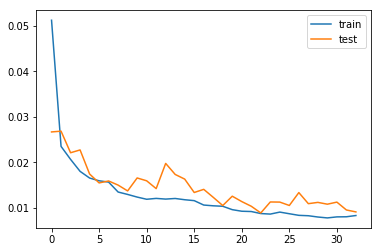

In [51]:
 # design network
K.clear_session()  # Clear previous models from memory.    
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(4))
model.compile(loss='mae', optimizer='adam')

epochs = 200
# fit network
history = model.fit(train_X, train_y, 
                    epochs=epochs, 
                    batch_size=72, 
                    validation_data=(val_X, val_y), 
                    verbose=2,
                    callbacks=callbacks,
                    shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.savefig("conf2-lstm-model.png")
pyplot.show()


# save the model
model.save("conf2-lstm-model.h5")

In [52]:
# save the model
model.save("conf2-lstm-model.h5")

In [57]:
# load test dataset
values = read_csv('bb-cross-test1.csv', header=0).values
print(len(values))
# ensure all data is float
values = values.astype('float32')

# normalize features

scaled = scaler.transform(values)
print(scaler.data_max_)
print(scaler.data_min_)

# specify the number of lag hours
n_seq = 15
n_features = 4
# frame as supervised learning
reframed = series_to_supervised(scaled, n_seq, 1)
print(reframed.shape)
values = reframed.values

# split into input and outputs
n_obs = n_seq * n_features
test_X, test_y = values[:, :n_obs], values[:, n_obs:n_obs+n_features]
print(test_X.shape, len(test_X), test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], n_seq, n_features))
print(test_X.shape, test_y.shape)

204
[1900.  953. 1919. 1079.]
[0. 0. 0. 0.]
(189, 64)
(189, 60) 189 (189, 4)
(189, 15, 4) (189, 4)


In [58]:
K.clear_session()  # Clear previous models from memory.    
model = load_model("conf2-lstm-model.h5")
# make a prediction
yhat = model.predict(test_X)

# invert scaling for forecast
inv_yhat = scaler.inverse_transform(yhat)

# invert scaling for actual
inv_y = scaler.inverse_transform(test_y)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 4.749


In [59]:
test_X.shape

(189, 15, 4)

In [60]:
test_X[0]

array([[0.3368421 , 0.70094436, 0.34601355, 0.67191845],
       [0.33631578, 0.6977964 , 0.34549242, 0.67099166],
       [0.33631578, 0.6956978 , 0.34549242, 0.67006487],
       [0.33578947, 0.6935991 , 0.34497133, 0.6691381 ],
       [0.33578947, 0.6925498 , 0.34445024, 0.6691381 ],
       [0.33526313, 0.6915005 , 0.3439291 , 0.6691381 ],
       [0.33526313, 0.6915005 , 0.3439291 , 0.6691381 ],
       [0.33473682, 0.6956978 , 0.34340802, 0.6691381 ],
       [0.33473682, 0.699895  , 0.34340802, 0.67099166],
       [0.33421052, 0.703043  , 0.3428869 , 0.67191845],
       [0.33421052, 0.70619094, 0.3428869 , 0.67284524],
       [0.3336842 , 0.70828956, 0.3423658 , 0.67469877],
       [0.3336842 , 0.7093389 , 0.3418447 , 0.67562556],
       [0.33315787, 0.7103882 , 0.34132358, 0.67840594],
       [0.33263156, 0.7114375 , 0.3408025 , 0.68118626]], dtype=float32)

In [61]:
yhat.shape

(189, 4)

In [151]:
import numpy as np
yhat =  model.predict(np.expand_dims(test_X[0], axis=0))

In [152]:
inv_yhat = scaler.inverse_transform(yhat)

In [153]:
inv_yhat

array([[1122.4075,  692.9786, 1214.8446,  859.0956]], dtype=float32)